**Download Dataset**

In [1]:
!wget "https://www.dropbox.com/s/elovlw3g8ylv85m/train.csv"

--2021-09-04 16:24:41--  https://www.dropbox.com/s/elovlw3g8ylv85m/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/elovlw3g8ylv85m/train.csv [following]
--2021-09-04 16:24:41--  https://www.dropbox.com/s/raw/elovlw3g8ylv85m/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceef46d84a649afab340b99e995.dl.dropboxusercontent.com/cd/0/inline/BViNoTu2w0QC3ekBpP3fn6YQiByEI4mXfkMEeC1yAMwdB6sWTylUbqW5gs4zY2q87y9aJWeWYyXlrycHPVXCoPsXk2H5p3SBBIADZ9XaWRI1jcXmbMjP4SIfMiqgcm0e07wH5UsFWHiAnCKzT4i2AvYG/file# [following]
--2021-09-04 16:24:42--  https://uceef46d84a649afab340b99e995.dl.dropboxusercontent.com/cd/0/inline/BViNoTu2w0QC3ekBpP3fn6YQiByEI4mXfkMEeC1yAMwdB6sWTylUbqW5gs4zY2q87y9aJWeWYyXlrycHPVXCoPsXk2H5p3SBBIA

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical

**Make Dataframe**

In [3]:
df=pd.read_csv('train.csv')

Emotions and Corresponding Labels

In [4]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

**Exploratory Data Analysis**

In [5]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


([<matplotlib.axis.XTick at 0x7f0fb4110c50>,
 [Text(0, 0, 'Angry'),
  Text(0, 0, 'Disgust'),
  Text(0, 0, 'Fear'),
  Text(0, 0, 'Happy'),
  Text(0, 0, 'Sad'),
  Text(0, 0, 'Surprise'),
  Text(0, 0, 'Neutral')])

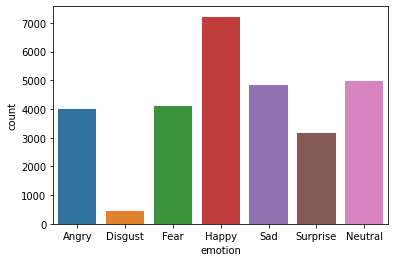

In [7]:
sns.countplot(data = df, x='emotion')
plt.xticks([0,1,2,3,4,5,6],emotions.values())

**Data Preprocessing**

We need class_weights to manage the class imbalances in the dataset.

In [8]:
class_weight = dict(zip(range(0, 7), (((df['emotion'].value_counts()).sort_index())/len(df['emotion'])).tolist()))

In [9]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

We need to Prepare the pixels that are currently in a 1D String format into 2D images and make a aray of these images.

In [10]:
def make_images_array(data):    
    images_array = np.zeros(shape=(len(data), 48, 48))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        images_array[i] = image
        
    return images_array

In [11]:
x = make_images_array(df)

In [12]:
y = df.emotion.to_numpy()

Displaying the first few images of the dataset.

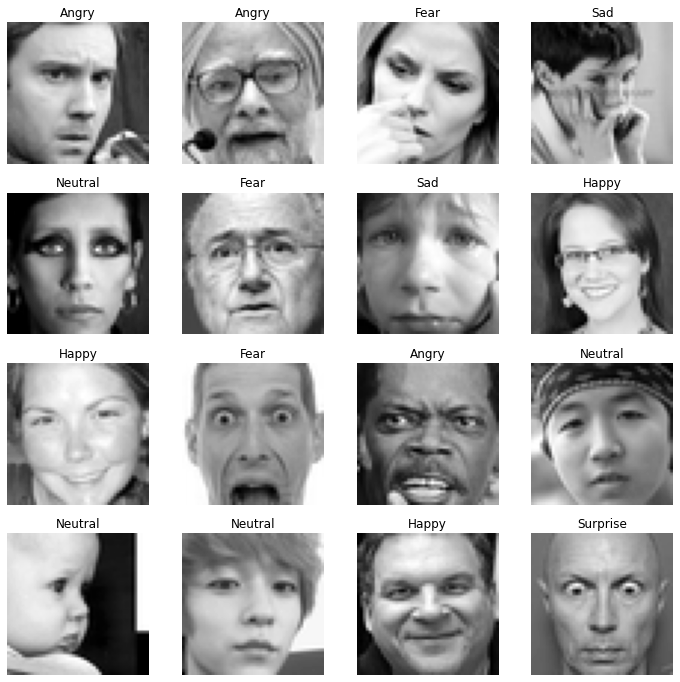

In [13]:
x_display = x[0:17,:,:]
y_display = y[0:17]
plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_display[i,:,:], cmap='binary_r')
    plt.title(emotions[y_display[i]])
    plt.axis('off')
plt.show()

Spliting data to train and test data.

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

Genrate Binary Matrix for classes.

In [15]:
y_train=to_categorical(y_train, num_classes=len(df.emotion.unique()))  
y_test=to_categorical(y_test, num_classes=len(df.emotion.unique())) 

Reshape the input Data to 4D as Convolution Layer needs a 4D input (Number of Images, width, height and depth of output)

In [16]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1) 

In [17]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [18]:
x_train.shape

(21531, 48, 48, 1)

**Model Building**

In [19]:
model = Sequential()

#convolution ( features of the image are get extracted within this layer) + relu (to make all negative value to zero) => 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
#pooling layer => Pooling layer is used to reduce the spatial volume of input image after convolution. It is used between two convolution layer
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten()) #Flattening is converting the data into a 1-dimensional array for inputting it to the next layer
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [20]:
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),class_weight = class_weight, epochs=10, batch_size=64)

Epoch 1/10
337/337 [==============================] - 34s 15ms/step - loss: 0.2708 - accuracy: 0.3081 - val_loss: 1.6240 - val_accuracy: 0.3844
Epoch 2/10
337/337 [==============================] - 5s 14ms/step - loss: 0.2360 - accuracy: 0.4163 - val_loss: 1.4867 - val_accuracy: 0.4469
Epoch 3/10
337/337 [==============================] - 5s 14ms/step - loss: 0.2169 - accuracy: 0.4612 - val_loss: 1.4531 - val_accuracy: 0.4673
Epoch 4/10
337/337 [==============================] - 5s 14ms/step - loss: 0.2025 - accuracy: 0.5013 - val_loss: 1.4107 - val_accuracy: 0.4833
Epoch 5/10
337/337 [==============================] - 5s 14ms/step - loss: 0.1911 - accuracy: 0.5279 - val_loss: 1.3623 - val_accuracy: 0.5077
Epoch 6/10
337/337 [==============================] - 5s 14ms/step - loss: 0.1818 - accuracy: 0.5514 - val_loss: 1.2856 - val_accuracy: 0.5261
Epoch 7/10
337/337 [==============================] - 5s 14ms/step - loss: 0.1733 - accuracy: 0.5745 - val_loss: 1.2978 - val_accuracy: 0.526

**Check Accuracy**

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('accuracy:', test_acc)

225/225 [==============================] - 1s 5ms/step - loss: 1.3311 - accuracy: 0.5272
accuracy: 0.5271663665771484


**Save Model and Weights**

In [23]:
model_json = model.to_json()
model.save_weights('fmm_model_weights.h5')
with open("fmm_model.json", "w") as json_file:
  json_file.write(model_json)